OpenFDA Adverse Events data (2019 Q1-3, source) analysis:
- data processing
- exploratory data analysis
- feature importance for mortality

Limitations of underlying data:
- A patient ID field (encrypted, of course) to link together adverse reports
- No HCP specialty field
- Comorbidities not directly reported (must be inferred from drugs taken)
- Multiple drugs can be reported as the 'suspect' drug so unable to draw direct conclusion
- Layout of dataset challenging for tabular usage

Analysis next steps:
- Expand years of data past 2019 and use full set of data rather than sample (better process to convert json without memory error)
- Check for all drug combinations rather than first couple combos
- Expand number of adverse events beyond those associated with drug in the first 'activesubstance' field (assumed to be primary)
- Build out model/feature importance further with top disease indications, active drugs, and reactions
- Construct more robust modeling pipeline (ie. training/testing, evaluation)

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
import gc

% matplotlib inline

pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# Data Processing

In [2]:
# 2019 Q1 data upload
path_to_fda_data = str(r'C:\Users\Dominic DeBiaso\Desktop\openfda_drug_adverse_events_2019_data\drug-event-')
fda_filename = str('-of-0032.json')

data_2019_q1 = json.load(open(path_to_fda_data + '0001' + fda_filename))
data_2019_q1 = pd.DataFrame(data_2019_q1["results"])

for i in range(2,33):
    print(i)
    if i < 10:
        path = path_to_fda_data + '000' + str(i) + fda_filename
    else:
        path = path_to_fda_data + '00' + str(i) + fda_filename
    temp = json.load(open(path))
    data_02_plus = pd.DataFrame(temp["results"])
    data_2019_q1 = pd.concat([data_2019_q1, data_02_plus])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [3]:
# 2019 Q2 data upload
path_to_fda_data = str(r'C:\Users\Dominic DeBiaso\Desktop\openfda_drug_adverse_events_2019_data\drug-event-')
fda_filename = str('-of-0034.json')

data_2019_q2 = json.load(open(path_to_fda_data + '0001' + fda_filename))
data_2019_q2 = pd.DataFrame(data_2019_q2["results"])

for i in range(2,35):
    print(i)
    if i < 10:
        path = path_to_fda_data + '000' + str(i) + fda_filename
    else:
        path = path_to_fda_data + '00' + str(i) + fda_filename
    temp = json.load(open(path))
    data_02_plus = pd.DataFrame(temp["results"])
    data_2019_q2 = pd.concat([data_2019_q2, data_02_plus])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [4]:
# 2019 Q3 data upload
path_to_fda_data = str(r'C:\Users\Dominic DeBiaso\Desktop\openfda_drug_adverse_events_2019_data\drug-event-')
fda_filename = str('-of-0037.json')

data_2019_q3 = json.load(open(path_to_fda_data + '0001' + fda_filename))
data_2019_q3 = pd.DataFrame(data_2019_q3["results"])

for i in range(2,38):
    print(i)
    if i < 10:
        path = path_to_fda_data + '000' + str(i) + fda_filename
    else:
        path = path_to_fda_data + '00' + str(i) + fda_filename
    temp = json.load(open(path))
    data_02_plus = pd.DataFrame(temp["results"])
    data_2019_q3 = pd.concat([data_2019_q3, data_02_plus])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [5]:
# combine 2019 quarter data together
df = pd.concat([data_2019_q1, data_2019_q2, data_2019_q3])
print(df.shape)

df = df.sample(10000, random_state=12)

(1216824, 27)


In [6]:
del [[data_2019_q1, data_2019_q2, data_2019_q3]]
gc.collect()

0

In [7]:
# data = json.load(open(r'C:\Users\Dominic DeBiaso\Desktop\openfda_drug_adverse_events_2019_data\drug-event-0001-of-0032.json'))
# df = pd.DataFrame(data["results"])

# df_sub = df.head(100)

# Data Munging

In [8]:
# subsetting fields not found in patient
df_other = df[['occurcountry', 'receivedate', 'serious', 
                   'seriousnesscongenitalanomali', 'seriousnessdeath', 
                   'seriousnessdisabling', 'seriousnesshospitalization', 
                   'seriousnesslifethreatening', 'seriousnessother']].reset_index(drop=True)
print(df_other.shape)

(10000, 9)


In [9]:
# flattening json data
from flatten_json import flatten

data = df['patient']
dict_flattened = (flatten(record, '.') for record in data)
df_patient = pd.DataFrame(dict_flattened)
df_patient = df_patient.reset_index(drop=True)
print(df_patient.shape)

# json_normalize(test['patient'], ['drug'], ['reaction'])

(10000, 235071)


In [10]:
# selecting only necessary columns for analysis
df_patient_activesubstancename = df_patient.filter(like='activesubstancename')
df_patient_reactionmeddrapt = df_patient.filter(like='reactionmeddrapt')
df_patient_sub = df_patient[['drug.0.drugcharacterization', 
            'drug.0.drugindication', 'patientagegroup', 'patientsex', 
            'drug.0.drugadministrationroute', 'patientweight', 
            'drug.0.actiondrug']]

df_patient_sub_concat = pd.concat([df_patient_activesubstancename, df_patient_reactionmeddrapt, df_patient_sub], axis=1)

In [11]:
# putting the datasets together
df_ads = pd.concat([df_patient_sub_concat, df_other], axis=1)
print(df_ads.shape)

# column used as a counter
df_ads['count'] = 1

(10000, 205)


In [12]:
# create counter columns
# drop duplicated names rowwse

def create_counter_var(df, current_col_name, stacking_col_name, counter_col_name):
    df_unstack = df.filter(like=current_col_name).unstack().to_frame(stacking_col_name).reset_index().drop_duplicates(
        ['level_1', stacking_col_name]).pivot(index='level_1', columns='level_0', values=stacking_col_name)
    
    df_count = df_unstack.notnull().astype('int')
    
    df_count = df_count.sum(axis=1).to_frame(counter_col_name).reset_index(drop=True)
    
    df = pd.concat([df, df_count], axis=1)
    
    return df

In [13]:
# counter for number of drugs
df_ads = create_counter_var(df_ads, 'activesubstancename', 'drug', 'drug_count')

# counter for number of adverse events
df_ads = create_counter_var(df_ads, 'reactionmeddrapt', 'reaction', 'reaction_count')

# Exploratory Data Analysis

Are different adverse events reported in different countries? 

In [14]:
# create function to keep a column constant but count number of occurrences of other columns that have the same name

def unstacking_for_analysis(df, constant_column, numbered_column, new_numbered_column, constant_new_numbered_column):
    
    # unstack the adverse events columns to do a frequency count
    # and also remove duplicates by level since is repeated per row/instance and want to avoid double counting
    
    df_unstacked = df.filter(like=numbered_column).unstack().to_frame(new_numbered_column).reset_index().drop_duplicates(
        ['level_1', new_numbered_column]).set_index('level_1')

    # join constant_column back on index to get counts by constant_column
    df_unstacked_counts = df_unstacked.join(df[[constant_column]])

    # retrieve counts of numbered_column per country
    df_unstacked_counts = df_unstacked_counts.groupby([constant_column, 
                                                       new_numbered_column]).size().to_frame('count').reset_index()

    # keep most common per constant_column
    df_unstacked_counts_first = df_unstacked_counts.sort_values([constant_column, 'count'], 
                                                                ascending=[True, False]).drop_duplicates(
        constant_column, keep='first')
    
    # charting results
    df_unstacked_counts_first[constant_new_numbered_column] = (df_unstacked_counts_first[constant_column] + '-' + 
                                                              df_unstacked_counts_first[new_numbered_column])
    
    return df_unstacked_counts_first

Text(0, 0.5, 'count')

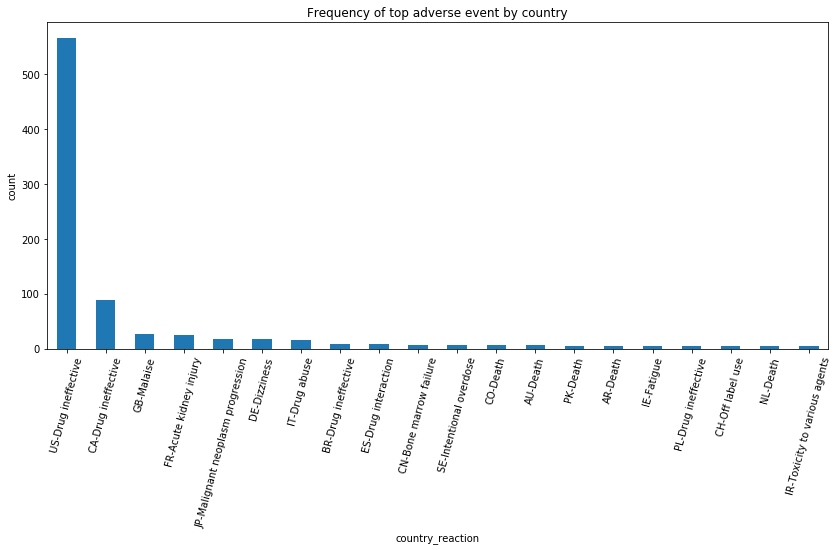

In [15]:
# running function
df_reaction_by_country = unstacking_for_analysis(df_ads, 'occurcountry', 'reactionmeddrapt', 'reaction', 'country_reaction')
df_reaction_by_country = df_reaction_by_country.sort_values('count', ascending=False).head(20)

chart = df_reaction_by_country.plot(kind='bar', x='country_reaction', y='count',
                                      title='Frequency of top adverse event by country', figsize=(14,6), rot=75, legend=False)
# chart.set_xlabel('')
chart.set_ylabel('count')

What are the different adverse events associated with different disease areas?

Text(0, 0.5, 'count')

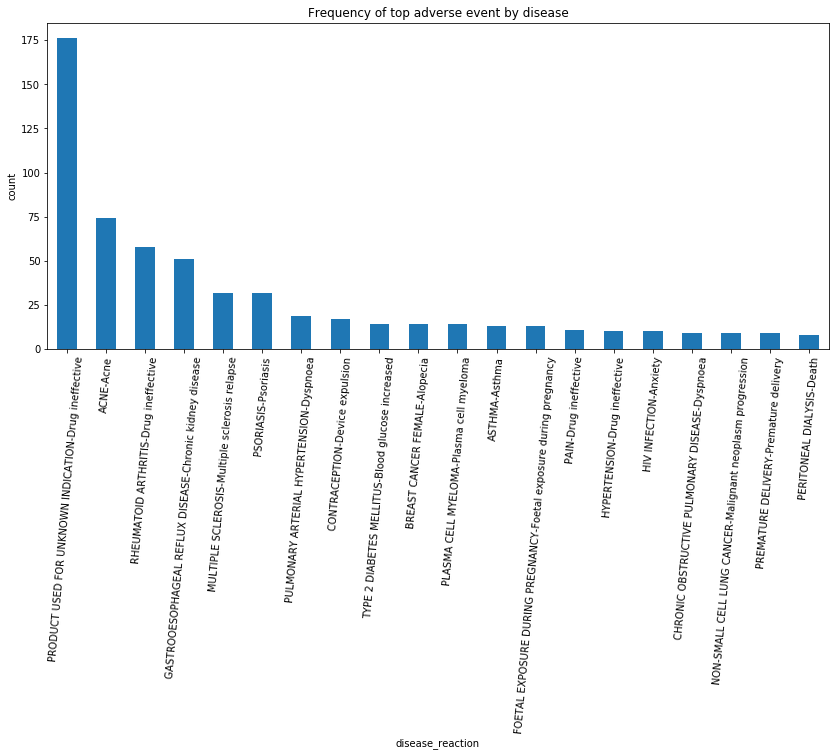

In [16]:
# preselect when the drug is the 'suspect drug' rather than a concommit or interaction drug
df_suspect = df_ads.loc[df_ads['drug.0.drugcharacterization'] == '1'].copy()

#
df_adverse_event_by_disease = unstacking_for_analysis(df_ads, 'drug.0.drugindication', 'reactionmeddrapt', 'reaction', 'disease_reaction')
df_adverse_event_by_disease = df_adverse_event_by_disease.sort_values('count', ascending=False).head(20)

chart = df_adverse_event_by_disease.plot(kind='bar', x='disease_reaction', y='count',
                                      title='Frequency of top adverse event by disease', figsize=(14,6), rot=85, legend=False)
# chart.set_xlabel('disease_reaction')
chart.set_ylabel('count')

What drugs tend to be taken together? 

In [17]:
# drop drug duplicates across columns to prepare dataset
# some drugs appear the same but the names are extended so are not dropped
df_drugs = df_ads.filter(like='activesubstancename').unstack().to_frame('drug').reset_index().drop_duplicates(
    ['level_1', 'drug']).pivot(index='level_1', columns='level_0', values='drug')

In [18]:
# count combinations for the first couple of columns 
def drug_activity(df, col_1, col_2):
    drug_combined = df.groupby([col_1, col_2]).size().reset_index().rename(columns={col_1:'drug_0', col_2:'drug_1'})
    return drug_combined

drug_01 = drug_activity(df_drugs, 'drug.0.activesubstance.activesubstancename', 'drug.1.activesubstance.activesubstancename')
drug_02 = drug_activity(df_drugs, 'drug.0.activesubstance.activesubstancename', 'drug.2.activesubstance.activesubstancename')
drug_03 = drug_activity(df_drugs, 'drug.0.activesubstance.activesubstancename', 'drug.3.activesubstance.activesubstancename')
drug_12 = drug_activity(df_drugs, 'drug.1.activesubstance.activesubstancename', 'drug.2.activesubstance.activesubstancename')
drug_23 = drug_activity(df_drugs, 'drug.2.activesubstance.activesubstancename', 'drug.3.activesubstance.activesubstancename')

drug_combined_list = [drug_01, drug_02, drug_03, drug_12, drug_23]

df_drug_combos = pd.concat(drug_combined_list, axis=0)

df_drug_combos_counts = df_drug_combos.groupby(['drug_0', 'drug_1']).size().to_frame('count').reset_index()

df_drug_combos_counts['combined_drugs'] = (df_drug_combos_counts['drug_0'] + '-' + 
                                           df_drug_combos_counts['drug_1'])
df_drug_combos_counts = df_drug_combos_counts.sort_values('count', ascending=False).head(5)

Text(0, 0.5, 'count')

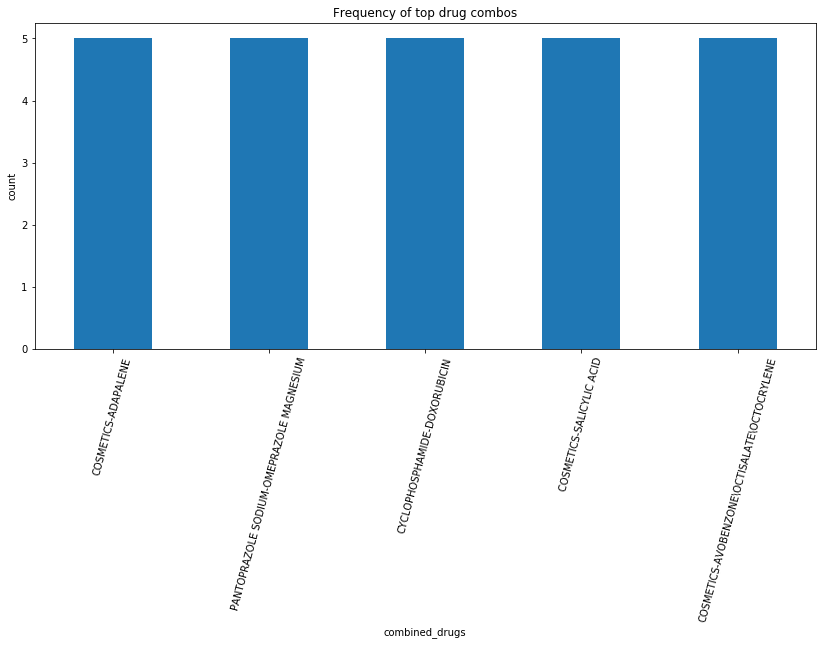

In [19]:
chart = df_drug_combos_counts.plot(kind='bar', x='combined_drugs', y='count',
                                      title='Frequency of top drug combos', figsize=(14,6), rot=75, legend=False)
# chart.set_xlabel('disease_reaction')
chart.set_ylabel('count')

Type of adverse events by drug

Text(0, 0.5, 'count')

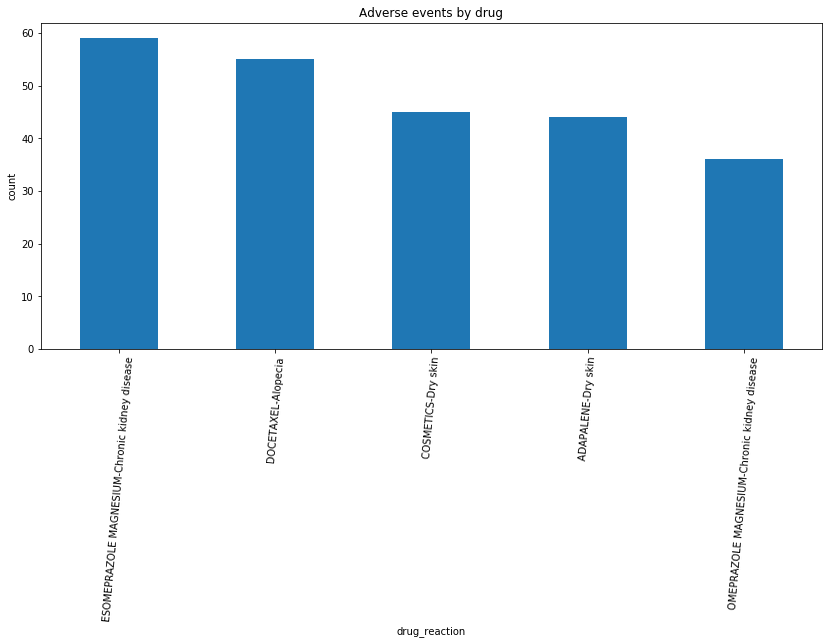

In [20]:
#
df_adverse_event_by_drug = unstacking_for_analysis(df_ads, 'drug.0.activesubstance.activesubstancename', 'reactionmeddrapt', 'reaction', 'drug_reaction')
df_adverse_event_by_drug = df_adverse_event_by_drug.sort_values('count', ascending=False).head(5)

chart = df_adverse_event_by_drug.plot(kind='bar', x='drug_reaction', y='count',
                                      title='Adverse events by drug', figsize=(14,6), rot=85, legend=False)
# chart.set_xlabel('disease_reaction')
chart.set_ylabel('count')

Count of adverse events by drug

Text(0, 0.5, 'reactions per drug')

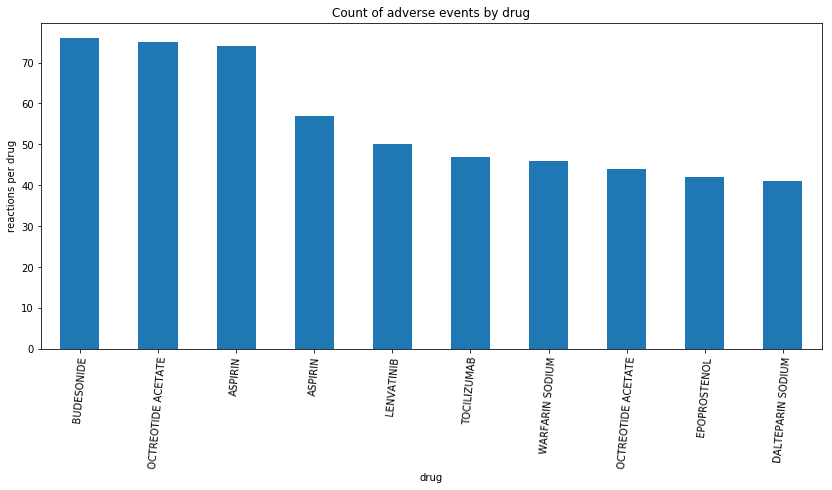

In [21]:
df_ads_adverse_event_by_drug = df_ads.sort_values(
    'reaction_count', ascending=False).head(10)[['drug.0.activesubstance.activesubstancename', 'reaction_count']]

chart = df_ads_adverse_event_by_drug.plot(kind='bar', x='drug.0.activesubstance.activesubstancename', y='reaction_count',
                                      title='Count of adverse events by drug', figsize=(14,6), rot=85, legend=False)
chart.set_xlabel('drug')
chart.set_ylabel('reactions per drug')

Percent of non-serious out of serious and non-serious by country

Text(0, 0.5, 'percent of reports non-serious')

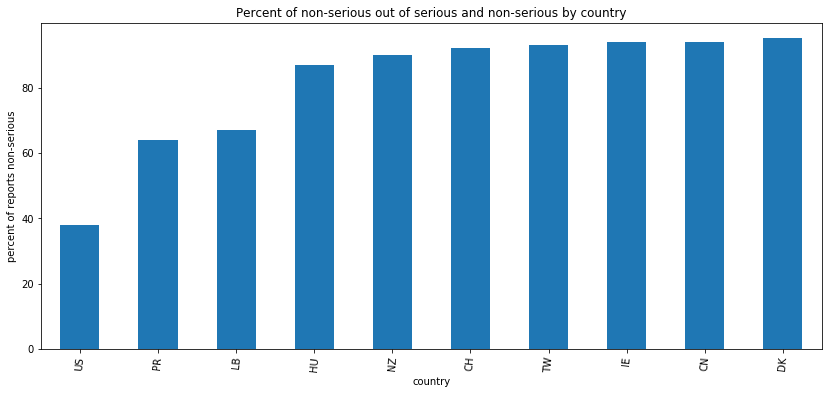

In [22]:
df_ae_total = df_ads['occurcountry'].value_counts().to_frame('count_total').reset_index()

df_ae_serious_1 = df_ads.loc[df_ads['serious'] == '1'][
    'occurcountry'].value_counts().to_frame('count_serious_1').reset_index()

df_ae_merged = pd.merge(df_ae_serious_1, df_ae_total)
df_ae_merged['percent'] = round(df_ae_merged['count_serious_1'] / df_ae_merged['count_total'] * 100)

df_ae_merged = df_ae_merged.sort_values('percent', ascending=True).head(10)

chart = df_ae_merged.plot(kind='bar', x='index', y='percent',
                                      title='Percent of non-serious out of serious and non-serious by country', figsize=(14,6), rot=85, legend=False)
chart.set_xlabel('country')
chart.set_ylabel('percent of reports non-serious')

Events reported by age group and sex

Text(0, 0.5, 'count')

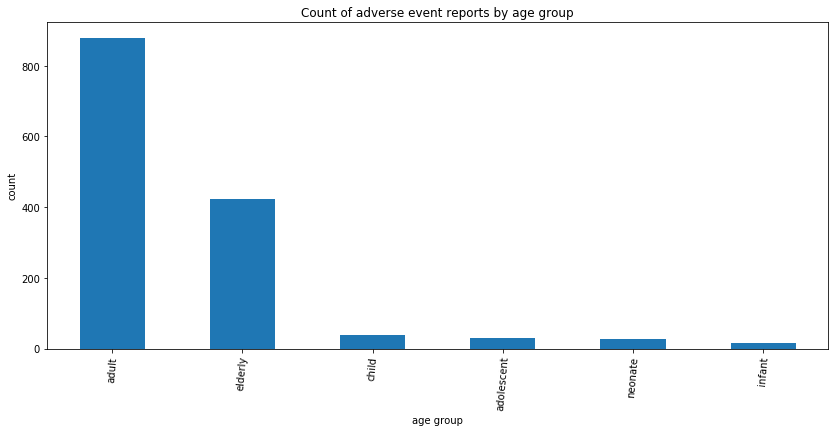

In [23]:
# distribution by age group
df_age_group = df_ads['patientagegroup'].value_counts().to_frame('count').reset_index()
df_age_group.loc[df_age_group['index'] == '1', 'index'] = 'neonate'
df_age_group.loc[df_age_group['index'] == '2', 'index'] = 'infant'
df_age_group.loc[df_age_group['index'] == '3', 'index'] = 'child'
df_age_group.loc[df_age_group['index'] == '4', 'index'] = 'adolescent'
df_age_group.loc[df_age_group['index'] == '5', 'index'] = 'adult'
df_age_group.loc[df_age_group['index'] == '6', 'index'] = 'elderly'

chart = df_age_group.plot(kind='bar', x='index', y='count',
                          title='Count of adverse event reports by age group', figsize=(14,6), rot=85, legend=False)
chart.set_xlabel('age group')
chart.set_ylabel('count')

Text(0, 0.5, 'count')

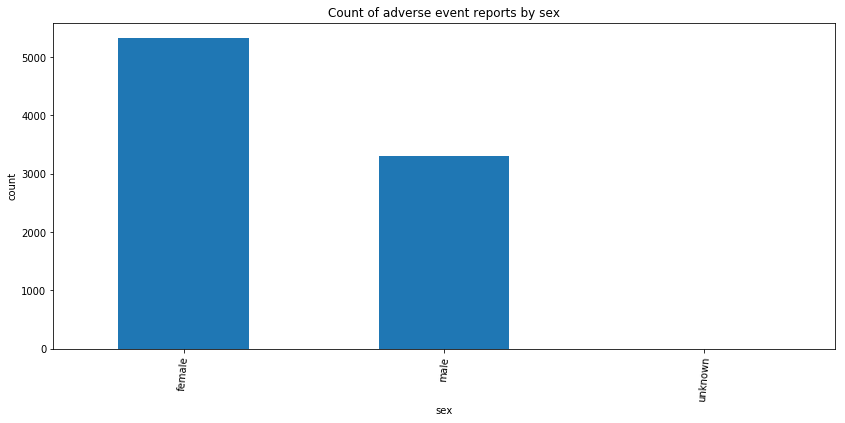

In [24]:
# distribution by sex
df_sex = df_ads['patientsex'].value_counts().to_frame('count').reset_index()
df_sex.loc[df_sex['index'] == '0', 'index'] = 'unknown'
df_sex.loc[df_sex['index'] == '1', 'index'] = 'male'
df_sex.loc[df_sex['index'] == '2', 'index'] = 'female'

chart = df_sex.plot(kind='bar', x='index', y='count',
                          title='Count of adverse event reports by sex', figsize=(14,6), rot=85, legend=False)
chart.set_xlabel('sex')
chart.set_ylabel('count')

Drug characterization by action drug by seriousness 

In [25]:
# combining seriousness indicators
df_ads.loc[(df_ads['seriousnesshospitalization'] == '1') |
           (df_ads['seriousnessother'] == '1'), 'seriousness_outcome'] = 'hospitalization or other condition'
df_ads.loc[(df_ads['seriousnesscongenitalanomali'] == '1') | 
           (df_ads['seriousnessdisabling'] == '1'), 'seriousness_outcome'] = 'congential anomaly or disability'
df_ads.loc[(df_ads['seriousnesslifethreatening'] == '1') | 
           (df_ads['seriousnessdeath'] == '1'), 'seriousness_outcome'] = 'life threatening condition or death'
df_ads['seriousness_outcome'] = df_ads['seriousness_outcome'].fillna('non-serious')

In [26]:
df_characterization_by_serious = df_ads.groupby(['drug.0.drugcharacterization', 'drug.0.actiondrug', 
                                                 'seriousness_outcome'])['count'].count().reset_index()

# defining the numbers
df_characterization_by_serious.loc[df_characterization_by_serious['drug.0.drugcharacterization'] == '1', 
                                   'drugcharacterization'] = 'Suspect'
df_characterization_by_serious.loc[df_characterization_by_serious['drug.0.drugcharacterization'] == '2', 
                                   'drugcharacterization'] = 'Concomitant'
df_characterization_by_serious.loc[df_characterization_by_serious['drug.0.drugcharacterization'] == '3', 
                                   'drugcharacterization'] = 'Interacting'

df_characterization_by_serious.loc[df_characterization_by_serious['drug.0.actiondrug'] == '1', 
                                   'actiondrug'] = 'Drug withdrawn'
df_characterization_by_serious.loc[df_characterization_by_serious['drug.0.actiondrug'] == '2', 
                                   'actiondrug'] = 'Drug reduced'
df_characterization_by_serious.loc[df_characterization_by_serious['drug.0.actiondrug'] == '3', 
                                   'actiondrug'] = 'Drug increased'
df_characterization_by_serious.loc[df_characterization_by_serious['drug.0.actiondrug'] == '4', 
                                   'actiondrug'] = 'Drug not changed'
df_characterization_by_serious.loc[df_characterization_by_serious['drug.0.actiondrug'] == '5', 
                                   'actiondrug'] = 'Unknown'
df_characterization_by_serious.loc[df_characterization_by_serious['drug.0.actiondrug'] == '6', 
                                   'actiondrug'] = 'Not applicable'

df_characterization_by_serious = df_characterization_by_serious.sort_values('count', ascending=False).head(10)
df_characterization_by_serious['drugCharacterization_actionDrug_seriousnessOutcome'] = (df_characterization_by_serious['drugcharacterization'] + '-' + 
                                    df_characterization_by_serious['actiondrug'] + '-' + 
                                    df_characterization_by_serious['seriousness_outcome'])

Text(0, 0.5, 'count')

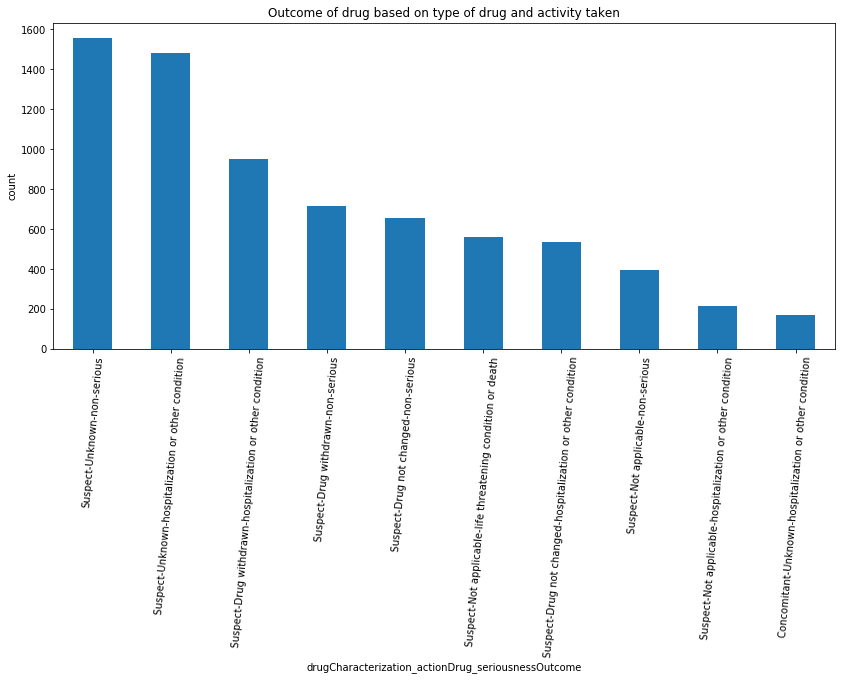

In [27]:
chart = df_characterization_by_serious.plot(kind='bar', x='drugCharacterization_actionDrug_seriousnessOutcome', y='count',
                          title='Outcome of drug based on type of drug and activity taken', figsize=(14,6), rot=85, legend=False)
chart.set_xlabel('drugCharacterization_actionDrug_seriousnessOutcome')
chart.set_ylabel('count')

# 1=Suspect
# 2=Concomitant
# 3=Interacting 

# 1=Drug withdrawn
# 2=Dose reduced
# 3=Dose increased
# 4=Dose not changed
# 5=Unknown
# 6=Not applicable 

Feature importance using mortality as target variable

In [28]:
# subsetting
df_model = df_ads[['patientagegroup', 'patientsex', 'patientweight', 'occurcountry',  
                   'drug.0.drugindication', 'drug.0.drugadministrationroute', 'drug.0.activesubstance.activesubstancename', 
                   'reaction.0.reactionmeddrapt', 'drug.0.actiondrug',
                   'drug_count', 'reaction_count',
                   'seriousnesshospitalization', 'seriousnessdeath']]

In [29]:
## feature engineering
# patientagegroup
df_model.loc[df_model['patientagegroup'] == '5', 'patientagegroup_adult'] = 1
df_model.loc[df_model['patientagegroup'] == '6', 'patientagegroup_elderly'] = 1

# patientsex
df_model.loc[df_model['patientsex'] == '1', 'patientsex_ismale'] = 1

# patientweight
df_model['patientweight'] = pd.to_numeric(df_model['patientweight'])
df_model['patientweight'] = df_model['patientweight'].fillna(df_model['patientweight'].median())

# occurcountry
df_model.loc[df_model['occurcountry'] == 'US', 'occurcountry_US'] = 1

# admin route
df_model['drug.0.drugadministrationroute'] = pd.to_numeric(
    df_model['drug.0.drugadministrationroute'], errors='coerce')

df_model.loc[(df_model['drug.0.drugadministrationroute'] >= 11) & 
             (df_model['drug.0.drugadministrationroute'] >= 43), 'drugadministrationroute_intraX'] = 1

# action drug
df_model.loc[df_model['drug.0.actiondrug'] == '1', 'actiondrug_withdrawn'] = 1
df_model.loc[df_model['drug.0.actiondrug'] == '2', 'actiondrug_dose_reduced'] = 1
df_model.loc[df_model['drug.0.actiondrug'] == '3', 'actiondrug_dose_increased'] = 1
df_model.loc[df_model['drug.0.actiondrug'] == '4', 'actiondrug_dose_same'] = 1

# drug count

# reaction count

# hospitalization
df_model['seriousnesshospitalization'] = pd.to_numeric(
    df_model['seriousnesshospitalization'])

# death
df_model['seriousnessdeath'] = pd.to_numeric(
    df_model['seriousnessdeath'])

In [30]:
# subsetting for model
df_model_ads = df_model[['patientagegroup_adult', 'patientagegroup_elderly', 'patientsex_ismale', 
                     'patientweight', 'occurcountry_US', 'drugadministrationroute_intraX', 
                     'actiondrug_withdrawn', 'actiondrug_dose_reduced', 'actiondrug_dose_increased', 
                     'actiondrug_dose_same', 'drug_count', 'reaction_count', 
                     'seriousnesshospitalization', 'seriousnessdeath']].fillna(0)

C:\Users\Dominic DeBiaso\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0, 0.5, 'feature')

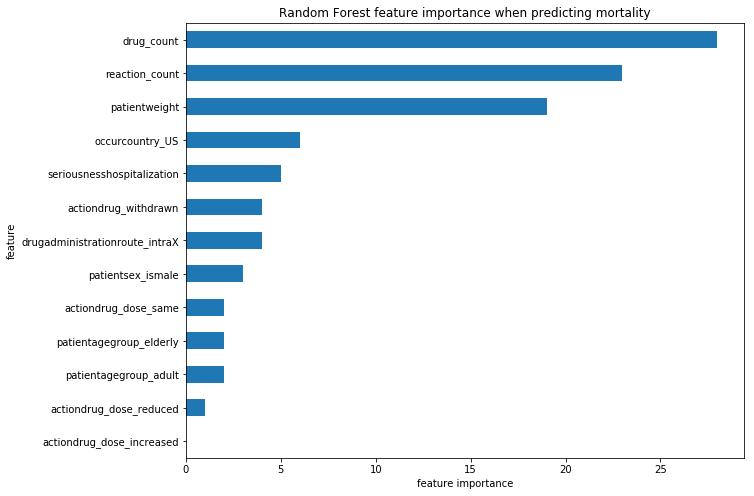

In [31]:
# mini model to get feature importance
X = df_model_ads.drop(['seriousnessdeath'], axis=1)
y = np.ravel(df_model_ads['seriousnessdeath'])

rfc = RandomForestClassifier(random_state=20)

rfc.fit(X, y)

feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)

feat_importances = round(feat_importances.sort_values(ascending=True)*100)

chart = feat_importances.plot(kind='barh', figsize=[10, 8], title='Random Forest feature importance when predicting mortality')
chart.set_xlabel('feature importance')
chart.set_ylabel('feature')